In [1]:
import matplotlib.pyplot as plt
from src import CompanyDetails
from neuralprophet import NeuralProphet
import pandas as pd

c:\Users\Aravind\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


In [2]:
c_symbol = 'ITC'
CompanyDetails = CompanyDetails(c_symbol)
stocks = CompanyDetails.sharePriceRange()
print(stocks)

            Date   Close      ema100      ema200
0     1996-01-01    3.13    3.130000    3.130000
1     1996-01-02    3.01    3.127624    3.128806
2     1996-01-03    2.92    3.123512    3.126728
3     1996-01-04    2.97    3.120473    3.125169
4     1996-01-05    2.92    3.116503    3.123127
...          ...     ...         ...         ...
7346  2025-04-04  409.70  430.259321  439.238367
7347  2025-04-07  406.05  429.779928  438.908134
7348  2025-04-08  412.55  429.438741  438.645864
7349  2025-04-09  416.30  429.178568  438.423517
7350  2025-04-11  421.55  429.027508  438.255621

[7351 rows x 4 columns]


In [3]:
stocks['Date'] = pd.to_datetime(stocks['Date'])
stocks = stocks[['Date', 'Close']]
stocks.columns = ['ds', 'y']
print(stocks)

             ds       y
0    1996-01-01    3.13
1    1996-01-02    3.01
2    1996-01-03    2.92
3    1996-01-04    2.97
4    1996-01-05    2.92
...         ...     ...
7346 2025-04-04  409.70
7347 2025-04-07  406.05
7348 2025-04-08  412.55
7349 2025-04-09  416.30
7350 2025-04-11  421.55

[7351 rows x 2 columns]


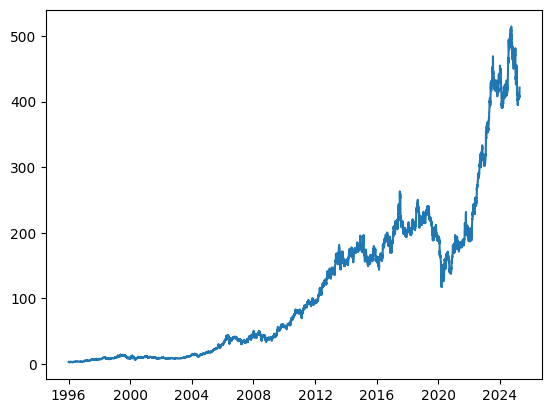

In [4]:
plt.plot(stocks['ds'], stocks['y'])

In [5]:
model = NeuralProphet()
model.fit(stocks)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - c:\Users\Aravind\AppData\Local\Programs\Python\Python39\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.368% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as B
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_bat

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (115) is too small than the required number                     for the learning rate finder (246). The results might not be optimal.
WARNING - (py.warnings._showwarnmsg) - c:\Users\Aravind\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.

WARNING - (py.warnings._showwarnmsg) - c:\Users\Aravind\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 55. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.

Finding best initial lr: 100%|██████████| 246/246 [00:02<00:00, 111.25it/s]


Training: |          | 0/? [00:49<?, ?it/s, v_num=1, train_loss=0.0123, reg_loss=0.000, MAE=20.10, RMSE=35.50, Loss=0.0123, RegLoss=0.000]


,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss,epoch
0,0.413385,0.0,276.559570,343.714783,0.413108,0.0,0
1,0.086284,0.0,84.165871,114.559196,0.086222,0.0,1
2,0.026107,0.0,36.665043,55.476387,0.026130,0.0,2
3,0.019185,0.0,30.577023,46.404213,0.019196,0.0,3
4,0.017204,0.0,27.898813,43.636696,0.017190,0.0,4
5,0.015817,0.0,25.991392,41.424126,0.015807,0.0,5
6,0.015265,0.0,25.479237,40.769085,0.015267,0.0,6
7,0.015219,0.0,25.975161,40.576214,0.015217,0.0,7
8,0.014686,0.0,25.918911,40.054680,0.014677,0.0,8
9,0.014947,0.0,26.371954,40.461121,0.014946,0.0,9


In [6]:
future = model.make_future_dataframe(stocks, periods=300)
print(future)

WARNING - (py.warnings._showwarnmsg) - c:\Users\Aravind\AppData\Local\Programs\Python\Python39\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.368% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\Aravind\AppData\Local\Programs\Python\Python39\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\Aravind\AppData\Local\Programs\Python\Python39\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be re

            ds     y
0   2025-04-14  None
1   2025-04-15  None
2   2025-04-16  None
3   2025-04-17  None
4   2025-04-18  None
..         ...   ...
295 2026-06-01  None
296 2026-06-02  None
297 2026-06-03  None
298 2026-06-04  None
299 2026-06-05  None

[300 rows x 2 columns]


In [7]:
forcast = model.predict(future)
actualPrediction = model.predict(stocks)

WARNING - (py.warnings._showwarnmsg) - c:\Users\Aravind\AppData\Local\Programs\Python\Python39\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 99.667% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\Aravind\AppData\Local\Programs\Python\Python39\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\Aravind\AppData\Local\Programs\Python\Python39\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be re

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 252.03it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (py.warnings._showwarnmsg) - c:\Users\Aravind\AppData\Local\Programs\Python\Python39\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.368% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\Aravind\AppData\Local\Programs\Python\Python39\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\Aravind\AppData\Local\Programs\Python\Python39\lib\site-packages\neur


Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 101.23it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [8]:
print(forcast)
print(actualPrediction)

            ds     y       yhat1       trend  season_yearly  season_weekly
0   2025-04-14  None  402.958618  406.804138      -1.948304      -1.897214
1   2025-04-15  None  403.370636  406.895203      -1.862536      -1.662045
2   2025-04-16  None  403.395782  406.986115      -1.781252      -1.809082
3   2025-04-17  None  403.423859  407.077087      -1.704639      -1.948592
4   2025-04-18  None  404.149780  407.167999      -1.632104      -1.386101
..         ...   ...         ...         ...            ...            ...
295 2026-06-01  None  441.399841  444.368500      -1.203228      -1.765405
296 2026-06-02  None  441.671539  444.459473      -1.241986      -1.545931
297 2026-06-03  None  441.460663  444.550354      -1.278979      -1.810716
298 2026-06-04  None  441.277069  444.641357      -1.313647      -2.050669
299 2026-06-05  None  442.141418  444.732239      -1.344941      -1.245885

[300 rows x 6 columns]
             ds       y       yhat1       trend  season_yearly  season_weekl

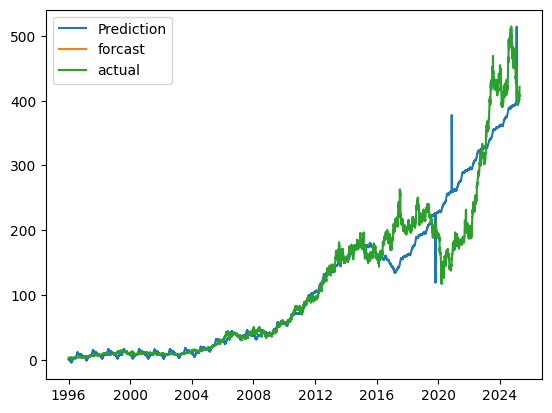

In [9]:
plt.plot(actualPrediction['ds'], actualPrediction['yhat1'])
plt.plot(forcast['ds'], forcast['y'])
plt.plot(stocks['ds'], stocks['y'])
plt.legend(['Prediction', 'forcast', 'actual'])